In [3]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split


In [4]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# Define the transformation: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and std of MNIST
])

# Download training set
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Download test set
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(" MNIST dataset downloaded successfully.")


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.56MB/s]

 MNIST dataset downloaded successfully.


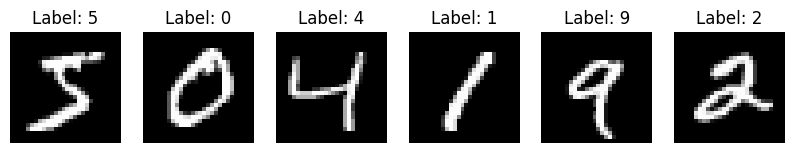

In [4]:
# Visualize a few samples
def show_samples(dataset, num_samples=6):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        image, label = dataset[i]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Call the visualization function
show_samples(train_dataset)


✅ Number of training samples: 60000
✅ Number of test samples: 10000

Class distribution in training set:
Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples


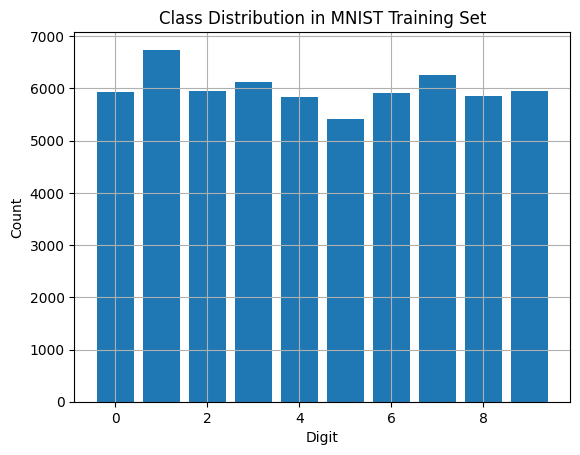


Image shape: torch.Size([1, 28, 28])
Pixel value range: min=-0.4242, max=2.8215


In [5]:
# Basic info
print(f"\u2705 Number of training samples: {len(train_dataset)}")
print(f"\u2705 Number of test samples: {len(test_dataset)}")

# Check balance of classes in the training set
labels = [label for _, label in train_dataset]
label_counts = Counter(labels)

print("\nClass distribution in training set:")
for digit in sorted(label_counts):
    print(f"Digit {digit}: {label_counts[digit]} samples")

# Optional: Plot class distribution
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Class Distribution in MNIST Training Set')
plt.grid(True)
plt.show()

# Sample image shape and range
image, label = train_dataset[0]
print(f"\nImage shape: {image.shape}")
print(f"Pixel value range: min={image.min():.4f}, max={image.max():.4f}")


In [6]:
from torch.utils.data import DataLoader  # Make sure this import is included

# Define transform (if not already defined)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_size = int(0.15 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1000, shuffle=False)


In [7]:
class Model_V1(nn.Module):
    def __init__(self):
        super(Model_V1, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

In [8]:
# Initialize model, loss function, and optimizer
model = Model_V1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


Epoch [5/15] - Train Loss: 0.0876 - Val Loss: 0.0748
Epoch [10/15] - Train Loss: 0.0653 - Val Loss: 0.0731
Epoch [15/15] - Train Loss: 0.0575 - Val Loss: 0.0718


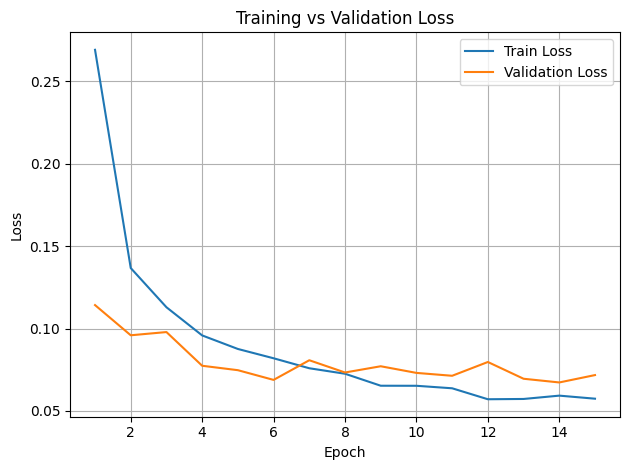

In [9]:
epochs = 15
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

# Plotting losses
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Prepare test data loader
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Evaluate on test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\n🧪 Test Accuracy of Model_V1: {100 * correct / total:.2f}%")



🧪 Test Accuracy of Model_V1: 98.14%


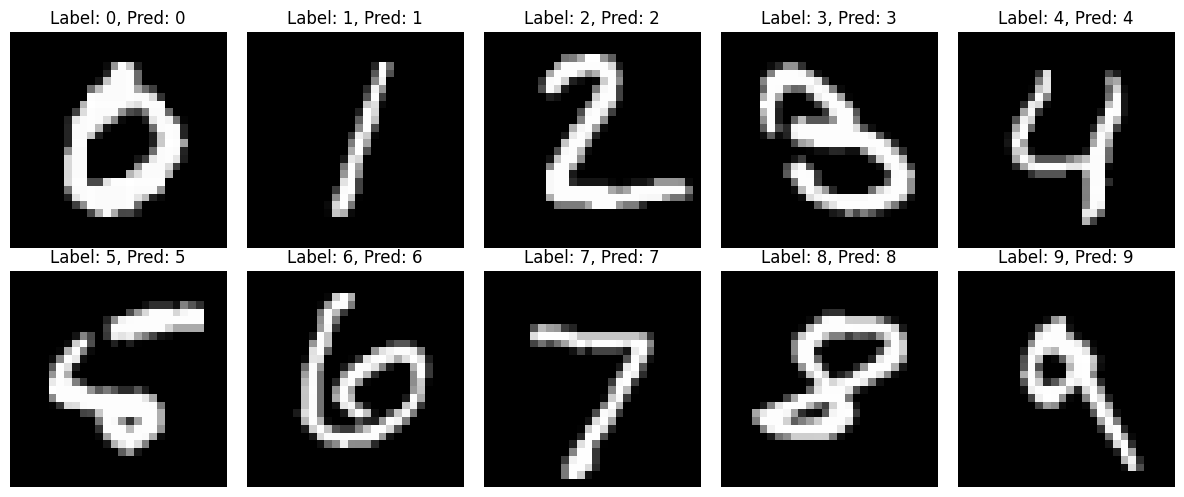

In [11]:
# Collect 1 example per digit
samples = {}
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        for img, label, pred in zip(images, labels, predictions):
            label = label.item()
            if label not in samples:
                samples[label] = (img.cpu(), pred.item())
            if len(samples) == 10:
                break
        if len(samples) == 10:
            break

#  Plot 1 image per class
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()
for i, digit in enumerate(sorted(samples.keys())):
    image, pred = samples[digit]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {digit}, Pred: {pred}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Epoch [5/15], Train Loss: 0.2208, Val Loss: 0.1946
Epoch [10/15], Train Loss: 0.1797, Val Loss: 0.1692
Epoch [15/15], Train Loss: 0.1581, Val Loss: 0.1570

Validation Accuracy of SimpleMNISTModel: 95.63%


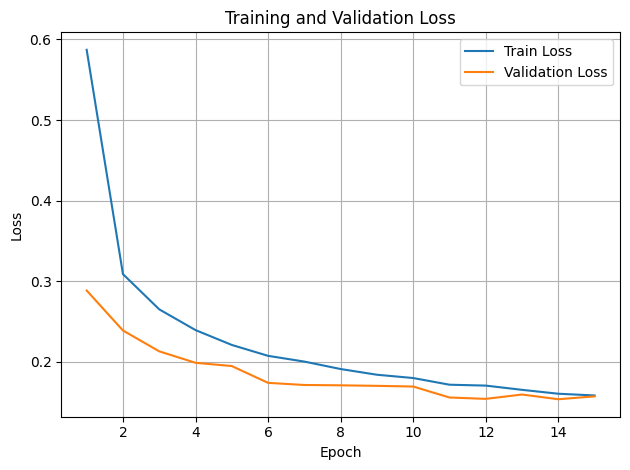

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform: normalize MNIST images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Split training set into training and validation sets (90% train, 10% val)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define simple model
class SimpleMNISTModel(nn.Module):
    def __init__(self):
        super(SimpleMNISTModel, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        return self.net(x)

# Initialize model, loss function, and optimizer
model = SimpleMNISTModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the model and record losses
epochs = 15
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Final Validation Accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\nValidation Accuracy of SimpleMNISTModel: {100 * correct / total:.2f}%")

# Plot training and validation loss
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Prepare test data loader (if not already defined)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Evaluate on test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\n Test Accuracy of SimpleMNISTModel: {100 * correct / total:.2f}%")



 Test Accuracy of SimpleMNISTModel: 96.35%
